In [20]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import seaborn as sns


df = pd.read_csv('https://raw.githubusercontent.com/USD-502-FinalProject/502-Summer2022-FinalProject/main/telecom_customer_churn.csv', sep=',')
df_zip = pd.read_csv('https://raw.githubusercontent.com/USD-502-FinalProject/502-Summer2022-FinalProject/main/telecom_zipcode_population.csv', sep=',')


# DATA QUALITY ##################################################################
#print(df.head(5))
#print(df.columns)


# Set flags here for output #####################################################
z_correlation_matrix = False

In [21]:
############################################################################
# Assign binary values for 'Customer Status' target variable
# Loop through each row of dataframe, assigning value for 'Customer Status'
# as either 0 or 1
for i, row in df.iterrows():

    val = 0  # default Stayed

    # Joined or Stayed
    if row['Customer Status'] == 'Stayed' or row['Customer Status'] == 'Joined':
        val = 0
    else:  # Churned
        val = 1

    df.at[i,'Customer Status'] = val


# Convert 'Customer Status' column into int/numeric
df['Customer Status'] = pd.to_numeric(df['Customer Status'])




In [22]:
print('Number of instances = %d' % (df.shape[0]))
print('Number of attributes = %d' % (df.shape[1]))
df.head()

Number of instances = 7043
Number of attributes = 38


,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,0,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,0,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,1,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,1,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,1,Dissatisfaction,Network reliability


In [23]:
for col in df.columns:
    print('\t%s: %d' % (col,df[col].isna().sum()))

	Customer ID: 0
	Gender: 0
	Age: 0
	Married: 0
	Number of Dependents: 0
	City: 0
	Zip Code: 0
	Latitude: 0
	Longitude: 0
	Number of Referrals: 0
	Tenure in Months: 0
	Offer: 0
	Phone Service: 0
	Avg Monthly Long Distance Charges: 682
	Multiple Lines: 682
	Internet Service: 0
	Internet Type: 1526
	Avg Monthly GB Download: 1526
	Online Security: 1526
	Online Backup: 1526
	Device Protection Plan: 1526
	Premium Tech Support: 1526
	Streaming TV: 1526
	Streaming Movies: 1526
	Streaming Music: 1526
	Unlimited Data: 1526
	Contract: 0
	Paperless Billing: 0
	Payment Method: 0
	Monthly Charge: 0
	Total Charges: 0
	Total Refunds: 0
	Total Extra Data Charges: 0
	Total Long Distance Charges: 0
	Total Revenue: 0
	Customer Status: 0
	Churn Category: 5174
	Churn Reason: 5174


In [24]:
print('Number of rows in original data = %d' % (df.shape[0]))

Number of rows in original data = 7043


In [25]:
df.dropna(how='any', inplace=True)

In [26]:
print('Number of rows after discarding missing values = %d' % (df.shape[0]))

Number of rows after discarding missing values = 1586


In [27]:
for col in df.columns:
    print('\t%s: %d' % (col,df[col].isna().sum()))

	Customer ID: 0
	Gender: 0
	Age: 0
	Married: 0
	Number of Dependents: 0
	City: 0
	Zip Code: 0
	Latitude: 0
	Longitude: 0
	Number of Referrals: 0
	Tenure in Months: 0
	Offer: 0
	Phone Service: 0
	Avg Monthly Long Distance Charges: 0
	Multiple Lines: 0
	Internet Service: 0
	Internet Type: 0
	Avg Monthly GB Download: 0
	Online Security: 0
	Online Backup: 0
	Device Protection Plan: 0
	Premium Tech Support: 0
	Streaming TV: 0
	Streaming Movies: 0
	Streaming Music: 0
	Unlimited Data: 0
	Contract: 0
	Paperless Billing: 0
	Payment Method: 0
	Monthly Charge: 0
	Total Charges: 0
	Total Refunds: 0
	Total Extra Data Charges: 0
	Total Long Distance Charges: 0
	Total Revenue: 0
	Customer Status: 0
	Churn Category: 0
	Churn Reason: 0


In [28]:
df.dtypes

Customer ID                           object
Gender                                object
Age                                    int64
Married                               object
Number of Dependents                   int64
City                                  object
Zip Code                               int64
Latitude                             float64
Longitude                            float64
Number of Referrals                    int64
Tenure in Months                       int64
Offer                                 object
Phone Service                         object
Avg Monthly Long Distance Charges    float64
Multiple Lines                        object
Internet Service                      object
Internet Type                         object
Avg Monthly GB Download              float64
Online Security                       object
Online Backup                         object
Device Protection Plan                object
Premium Tech Support                  object
Streaming 

In [29]:
df2 = df.drop(['Customer ID', 
                     'Number of Dependents', 'Gender', 'Married', 'City', 'Zip Code', 'Latitude', 'Longitude', 'Offer', 'Phone Service', 'Internet Type', 'Multiple Lines', 'Internet Service', 
                     'Online Security', 'Online Backup',
                     'Device Protection Plan', 'Premium Tech Support',
                     'Streaming TV', 'Streaming Music', 'Streaming Movies',
                     'Unlimited Data', 'Contract', 'Paperless Billing',
                     'Payment Method', 'Customer Status', 'Churn Category',
                     'Churn Reason'],axis=1)

<AxesSubplot:>

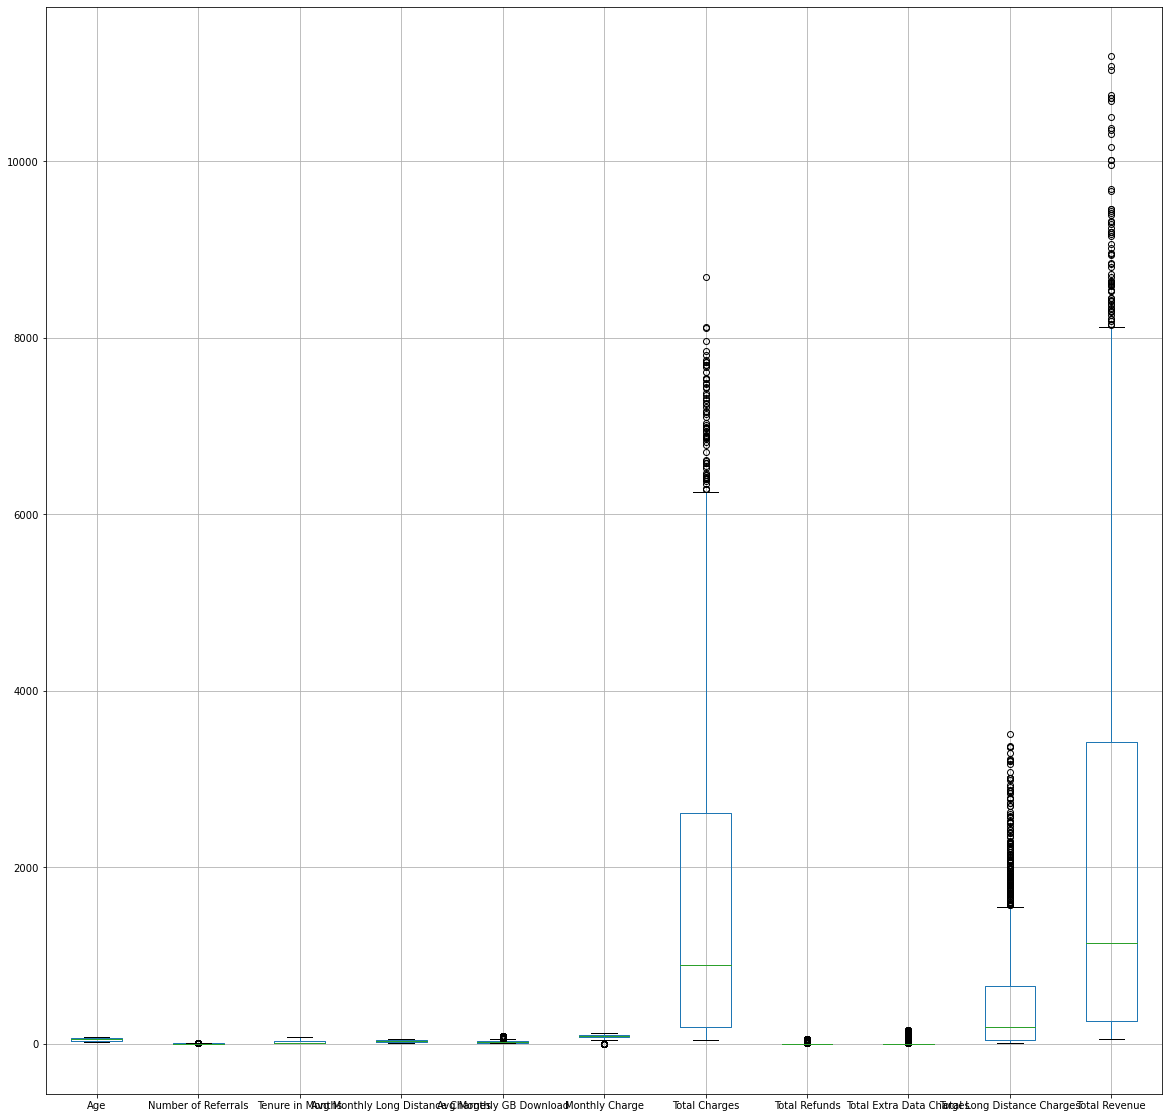

In [30]:
df2.boxplot(figsize=(20, 20))

<AxesSubplot:xlabel='Total Revenue'>

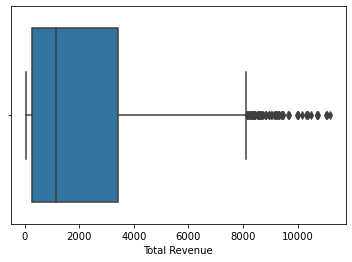

In [31]:
sns.boxplot(x=df['Total Revenue'])

In [32]:
Z = (df2-df2.mean())/df2.std()

In [33]:
Z

,Age,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
2,-0.009377,-0.476960,-0.754222,0.569924,0.369296,-0.363800,-0.730659,-0.225912,-0.292616,-0.534479,-0.710106
3,1.573915,0.414040,-0.298740,0.161545,-1.096091,0.852454,-0.244479,-0.225912,-0.292616,-0.199164,-0.244503
4,1.404276,2.196039,-0.804831,-1.270232,-0.701564,0.140870,-0.737492,-0.225912,-0.292616,-0.700557,-0.759618
18,1.630461,-0.476960,1.320751,-1.039775,-0.363397,-0.929030,0.544813,-0.225912,-0.292616,-0.024182,0.413027
21,-1.366484,0.414040,-0.298740,1.264097,1.609240,0.655633,-0.255783,-0.225912,-0.292616,0.103012,-0.172790
...,...,...,...,...,...,...,...,...,...,...,...
7013,-0.348654,0.414040,0.966487,0.707217,-0.588842,-0.083708,0.657366,1.038429,1.298093,1.265082,0.855494
7020,1.630461,-0.476960,0.106132,1.173736,-0.927008,-4.143777,0.158105,1.151895,-0.292616,0.577631,0.269940
7023,1.291184,-0.476960,-0.501177,-1.083905,-0.588842,0.138347,-0.471922,-0.225912,-0.292616,-0.599812,-0.527233
7036,0.160262,-0.476960,-0.906050,1.161127,-0.814286,-0.553051,-0.837700,-0.225912,-0.292616,-0.671095,-0.829337


In [34]:
print('Number of rows before discarding outliers = %d' % (Z.shape[0]))

Z2 = Z.loc[((Z > -3).sum(axis=1)==11) & ((Z <= 3).sum(axis=1)==11),:]
print('Number of rows after discarding missing values = %d' % (Z2.shape[0]))

Number of rows before discarding outliers = 1586
Number of rows after discarding missing values = 1356


In [35]:
dups = df2.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 0


In [36]:
# FEATURE SCALING - STANDARDIZING THE COLUMN VALUES - NUMERIC ONLY ############
# NOT NEEDED for our binary classifier models but we keep it here commented out
# in case the need arises
# Logistic Regression, Decision Tree, Random Forest, Naive Bayes, SVM
# are not sensitive to the magnitude of variables, so feature scaling not
# required
# Only required if the logistic regression is regularized in which case
# the input needs to be normalized
#df_numeric = df._get_numeric_data()
#Z = (data2-data2.mean())/data2.std()

In [37]:
################################################################################################
# NORMALIZE THE NUMERIC COLUMNS
# Only necessary for models like KNN, not necessary for logistic regression
################################################################################################
scaler = MinMaxScaler()

# normalize all the numeric columns in df
df_numeric_columns = df._get_numeric_data()

# remove Zip Code, Longitude, Latitude, normalizing these makes no sense
df_numeric_columns = df_numeric_columns.drop(['Zip Code', 'Longitude', 'Latitude', 'Customer Status'], axis=1)

# Perform the transformation on the data so that it is scaled to range 0-1
df_scaled = scaler.fit_transform(df_numeric_columns)

# create a new dataframe containing the normalized values and corresponding column names
#norm = pd.DataFrame(df_scaled, columns = df._get_numeric_data().columns)
norm = pd.DataFrame(df_scaled, columns = df_numeric_columns.columns)

norm.head(2)

# Takes df_master dataframe and replaces the normalized columns from norm_df
def replace_norms(df_master, df_norm):
    cols = df_norm.columns
    for col in cols:
        df_master[col] = df_norm[col]

replace_norms(df, norm)
df.head(2)

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
2,0004-TLHLJ,Male,0.918033,No,0.0,Costa Mesa,92627,33.645672,-117.922613,0.333333,...,Bank Withdrawal,0.729486,0.025978,0.0,0.0,0.005990,0.021763,1,Competitor,Competitor had better devices
3,0011-IGKFF,Male,0.983607,Yes,0.0,Martinez,94553,38.014457,-122.115432,0.000000,...,Bank Withdrawal,0.563015,0.318055,0.0,0.0,0.136563,0.289252,1,Dissatisfaction,Product dissatisfaction


In [38]:
################################################################################################
# ONE HOT ENCODING
# One method used to handle the categorical columns and expands them out into binary form
# Disadvantage: Creates a lot of additional columns
# Use for non-ordinal categorical values and when there are not so many categorical values per column
# Typically use PCA reduction afterwards because it produces too many columns
# https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/
# https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor
# https://www.ritchieng.com/machinelearning-one-hot-encoding/
# https://stats.stackexchange.com/questions/48360/is-standardization-needed-before-fitting-logistic-regression#:~:text=You%20don't%20need%20to,helps%20interpretability%2C%20and%20rarely%20hurts.
#
# Issues to check on:
# Does zip code or city have any correlation to Churn ?
# Correlation matrix shows that City has very little correlation with Churn,
# so for now we don't hotencode.  Zip Code with city-data.com may provide
# additional insight into the demographic data relating to a zipcode but
# that is extra if we have time.
################################################################################################

# Select all categorical value columns, they will be of type object
df_cat_cols = pd.DataFrame(df.dtypes[df.dtypes == 'object'])

# fill any missing values with "other" and then drop these columns after the hot encoding
df_cat_cols = df_cat_cols.fillna("other", axis="index")

cat_cols = np.array(df_cat_cols.index)

# We do not need to onehotencode Customer Status because this is the target
# variable.  Customer ID is irrelevant.
# Not sure what to do about City right now, it increases the dimensionality
# by too much.  We can decide what do with it later after I get the model
# working.
#cat_cols = np.array(pd.DataFrame(df.dtypes[df.dtypes == 'object']).index)
#cat_cols = np.delete(cat_cols, 20) # remove the target variable 'Customer Status'
cat_cols = np.delete(cat_cols, 0)  # remove Customer ID
cat_cols = np.delete(cat_cols, 2)  # remove City - no correlation from matrix
#cat_cols = df.select_dtypes(include=[object])


# Drop the first feature in the category
#ohe = OneHotEncoder(drop = 'first').fit(df[cat_cols])
ohe = OneHotEncoder().fit(df[cat_cols])
# why don't you just get_dummies()?

# perform the one hot encoding on the categorical columns
# assign it to an array type
# We end up with 8200 columns....too big!
ohe_array = ohe.fit_transform(df[cat_cols]).toarray()

# Take the array of one hot encoded columns and create a dataframe out of it
ohe_df = pd.DataFrame(ohe_array, index = df.index, columns = ohe.get_feature_names(cat_cols))

# Drop the categorical columns from the original dataframe
df_drop_col = df.drop(columns = cat_cols)

# Merge the one hot encoded columns and the dataframe containing the dropped columns
df_ohed = pd.concat([df_drop_col, ohe_df], axis = 1)
df_ohed.columns
print(df_ohed.head(2))


  Customer ID       Age  Number of Dependents        City  Zip Code  \
2  0004-TLHLJ  0.918033                   0.0  Costa Mesa     92627   
3  0011-IGKFF  0.983607                   0.0    Martinez     94553   

    Latitude   Longitude  Number of Referrals  Tenure in Months  \
2  33.645672 -117.922613             0.333333          0.028169   
3  38.014457 -122.115432             0.000000          0.619718   

   Avg Monthly Long Distance Charges  ...  \
2                           0.129902  ...   
3                           0.197100  ...   

   Churn Reason_Lack of self-service on Website  \
2                                           0.0   
3                                           0.0   

   Churn Reason_Limited range of services  Churn Reason_Long distance charges  \
2                                     0.0                                 0.0   
3                                     0.0                                 0.0   

   Churn Reason_Moved  Churn Reason_Network reliab

/Users/vannesasalazar/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [39]:
################################################################################################
# PCA reduction to reduce the number of columns from 8200 down to something more realistic
# to feed to the logistic regression model
################################################################################################
'''
from sklearn import datasets  # to retrieve the iris Dataset
import pandas as pd  # to load the dataframe
from sklearn.preprocessing import StandardScaler  # to standardize the features
from sklearn.decomposition import PCA  # to apply PCA
import seaborn as sns  # to plot the heat maps


#Standardize the features
#Create an object of StandardScaler which is present in sklearn.preprocessing
scalar = StandardScaler()
scaled_data = pd.DataFrame(scalar.fit_transform(df.select_dtypes(include=[np.number]))) #scaling the data
scaled_data

# clean up NaN
# drop all rows containing NaN
# https://sparkbyexamples.com/pandas/pandas-drop-rows-with-nan-values-in-dataframe/#:~:text=By%20using%20dropna()%20method,you%20should%20use%20inplace%3DTrue%20.
scaled_data = scaled_data.dropna()



#Check the Co-relation between features without PCA
sns.heatmap(scaled_data.corr())


#Applying PCA
#Taking no. of Principal Components as 3
pca = PCA(n_components = 3)
pca.fit(scaled_data)
data_pca = pca.transform(scaled_data)
data_pca = pd.DataFrame(data_pca,columns=['PC1','PC2','PC3'])
data_pca.head()



#Checking Co-relation between features after PCA
sns.heatmap(data_pca.corr())
'''


"\nfrom sklearn import datasets  # to retrieve the iris Dataset\nimport pandas as pd  # to load the dataframe\nfrom sklearn.preprocessing import StandardScaler  # to standardize the features\nfrom sklearn.decomposition import PCA  # to apply PCA\nimport seaborn as sns  # to plot the heat maps\n\n\n#Standardize the features\n#Create an object of StandardScaler which is present in sklearn.preprocessing\nscalar = StandardScaler()\nscaled_data = pd.DataFrame(scalar.fit_transform(df.select_dtypes(include=[np.number]))) #scaling the data\nscaled_data\n\n# clean up NaN\n# drop all rows containing NaN\n# https://sparkbyexamples.com/pandas/pandas-drop-rows-with-nan-values-in-dataframe/#:~:text=By%20using%20dropna()%20method,you%20should%20use%20inplace%3DTrue%20.\nscaled_data = scaled_data.dropna()\n\n\n\n#Check the Co-relation between features without PCA\nsns.heatmap(scaled_data.corr())\n\n\n#Applying PCA\n#Taking no. of Principal Components as 3\npca = PCA(n_components = 3)\npca.fit(scaled_d

In [40]:
################################################################################################
# CORRELATION MATRIX to explore relationships between variables
# We want to see the relationship of categorical variables against the 'Customer Status' (churn) target variable
# https://github.com/shakedzy/dython/blob/master/docs/getting_started/examples.md
# 0 = no association, 1 = associated
################################################################################################
# Categorical Data
'''
if z_correlation_matrix == True:
    #plt.rcParams.update({'font.size': 8})
    corr_df_cat = df_ohed.drop(columns=['Customer ID', 'Age', 'City', 'Zip Code', 'Latitude', 'Longitude'])
    #corr_df_cat = df[['Gender', 'Married','City', 'Offer', 'Phone Service', 'Multiple Lines', 'Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Unlimited Data', 'Contract', 'Paperless Billing', 'Payment Method', 'Churn Category', 'Customer Status']]
    #nominal.associations(corr_df_cat, nominal_columns = 'auto', figsize=(15, 15), annot =True)

    # Your data should be a pandas dataframe for this example
    corr_matrix = corr_df_cat.corr()
    matrix = corr_matrix["Customer Status"].sort_values(ascending=False)
    # why does the above turn Customer Status into nan?
    #matrix = matrix.unstack()
    matrix = matrix[abs(matrix) >= 0]

    # sideways bar chart of anything

    corr_matrix.to_csv('correlation_matrix.csv')
    print(matrix.head(25))
'''

'\nif z_correlation_matrix == True:\n    #plt.rcParams.update({\'font.size\': 8})\n    corr_df_cat = df_ohed.drop(columns=[\'Customer ID\', \'Age\', \'City\', \'Zip Code\', \'Latitude\', \'Longitude\'])\n    #corr_df_cat = df[[\'Gender\', \'Married\',\'City\', \'Offer\', \'Phone Service\', \'Multiple Lines\', \'Internet Type\', \'Online Security\', \'Online Backup\', \'Device Protection Plan\', \'Premium Tech Support\', \'Streaming TV\', \'Streaming Movies\', \'Unlimited Data\', \'Contract\', \'Paperless Billing\', \'Payment Method\', \'Churn Category\', \'Customer Status\']]\n    #nominal.associations(corr_df_cat, nominal_columns = \'auto\', figsize=(15, 15), annot =True)\n\n    # Your data should be a pandas dataframe for this example\n    corr_matrix = corr_df_cat.corr()\n    matrix = corr_matrix["Customer Status"].sort_values(ascending=False)\n    # why does the above turn Customer Status into nan?\n    #matrix = matrix.unstack()\n    matrix = matrix[abs(matrix) >= 0]\n\n    # side